# Data Science and Web Mining

## Regression problem: Predict how many bikes will be rented during any given hour of the day
The goal of the given assignment is to create a model, which predicts the number of bikes that will be rented at any hour of any day, based on information in the dataset.

## Project Team
* Konstantinos Xarhoulakos 3160121
* Thodoris Tsigkanos 3160180
* Christos Charmantas 3160189

**Kaggle Team : Geese**

## Dataset
The dataset given consists of the following features:

* __Season__ &#8594; (1,2,3,4) The current season
* __Yr__ &#8594; (0,1) The two years our company has been functioning
* __Mnth__ &#8594; (1-12) The current month
* __Hr__ &#8594; (0-23) The current hour of the day
* __Holiday__ &#8594; (0,1) Refers to whether the current day is a holiday or not
* __Weekday__ &#8594; (0-6) The current day of the week 
* __WorkingDay__ &#8594; (0,1) Refers to whether the current day is a Business day or not 
* __Weathersit__ &#8594; (1,2,3,4) Refers to a general weather condition(1:Clear or Partly Cloudy, 2:Misty & Cloudy, 3:Light Snow/Rain, 4:Heavy rain, Hail, Thunderstorm, Snow) 
* __Temp__ &#8594; The temperature of the current hour
* __Atemp__ &#8594; Normalize feeling temperature
* __Hum__ &#8594; The humidity of the current hour
* __Windspeed__ &#8594; The windspeed of the current hour 
* __Casual__ &#8594; The number of casual(non-registered) users for the current hour
* __Registered__ &#8594; The number of registered users for the current hour
* __Cnt__ &#8594; The total number of rented bikes for the current hour 

## Time Series Analysis
Given the sorted dataset, we decided to use the factor of time, in order to forecast the rents of bikes in the next period of time. That is why we tried the time series analysis.
First we had to check our dataset for stationarity, seasonality and autocorrelated variables.

The result of this script was that the dataset is stationary.

In [1]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np

class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None

    def ADF_Stationarity_Test(self, timeseries, printResults=True):
        # Dickey-Fuller test:
        adfTest = adfuller(timeseries, autolag='AIC')

        self.pValue = adfTest[1]

        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False

        if printResults:
            dfResults = pd.Series(adfTest[0:4],
                                  index=['ADF Test Statistic', 'P-Value', '# Lags Used', '# Observations Used'])
            # Add Critical Values
            for key, value in adfTest[4].items():
                dfResults['Critical Value (%s)' % key] = value
            print('Augmented Dickey-Fuller Test Results:')
            print(dfResults)

df = pd.read_csv('train.csv')
df=df[['cnt']]
dfar=df.values
ar=np.delete(dfar,[1,2],axis=1)
ar=ar.ravel()
sTest = StationarityTests()
sTest.ADF_Stationarity_Test(ar, printResults = True)
print("Is the time series stationary? {0}".format(sTest.isStationary))

C:\Users\chris\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


Augmented Dickey-Fuller Test Results:
ADF Test Statistic        -63.701891
P-Value                     0.000000
# Lags Used                 2.000000
# Observations Used     12162.000000
Critical Value (1%)        -3.430888
Critical Value (5%)        -2.861778
Critical Value (10%)       -2.566897
dtype: float64
Is the time series stationary? True


Then we tested some parameters in SARIMAX to find the optimal model and used it to predict the next hours.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


import warnings
print('running')
warnings.filterwarnings('ignore')

DATAPATH = 'train.csv'

data = pd.read_csv(DATAPATH)
data = data[['cnt']]
X_train, X_test = train_test_split(data, test_size=0.2, random_state=0)

# SARIMA
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

# Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


# Train many SARIMA models to find the best set of parameters
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float('inf')
    for param in tqdm_notebook(parameters_list):
        try:
            model = sm.tsa.statespace.SARIMAX(X_train.head(100), order=(param[0], d, param[1]),
                                              seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        # Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table



result_table = optimize_SARIMA(parameters_list, d, D, s)

# Set parameters that give the lowest AIC (Akaike Information Criteria)
p, q, P, Q = result_table.parameters[0]
best_model = sm.tsa.statespace.SARIMAX(X_train, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)
x_pred = best_model.predict()
x_pred[x_pred<0]=0
print(best_model.summary())

mod_Test=X_test
mod_Pred=x_pred
if len(X_test)!=len(x_pred):
    if len(X_test)>len(x_pred):
        mod_Test=X_test.head(len(x_pred))
    else:
        mod_Pred=x_pred.head(len(X_test))
print('RMSLE:', np.sqrt(mean_squared_log_error(mod_Test, mod_Pred)))
print('R2:', r2_score(mod_Test, mod_Pred))

running



                                 Statespace Model Results                                
Dep. Variable:                               cnt   No. Observations:                 9732
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 5)   Log Likelihood              -64348.255
Date:                           Sat, 28 Dec 2019   AIC                         128702.509
Time:                                   21:55:28   BIC                         128724.057
Sample:                                        0   HQIC                        128709.813
                                          - 9732                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9993      0.001  -1238.974      0.000      -1.001      -0.998
ma.S.L5       -0.9996      0.002   -431.82

The parameters of the best model are: ps=0, d=1, qs=1, Ps=0, D=1, Qs=1 and s=5.

## The code of the final score
Having tried a lot of regressors and many parameters for each one of them, time series analysis, many different ensemble models and many modifications on our dataset, this algorithm has given the best results and our final submission.

### Dataset modifications
After testing a few basic premade models from libraries, as well as reasearch on the subject of Data Mining, it was clear that our dataset required more features, in order to make a proper prediction. Therefore, we created a few extra features, by combining the original data, to assist the model in its predictions.
The added data is the following:

#### Average count group by month, split by year
* __Cnt_byYear_byMonth__ &#8594; Represents the average number of users each month per year
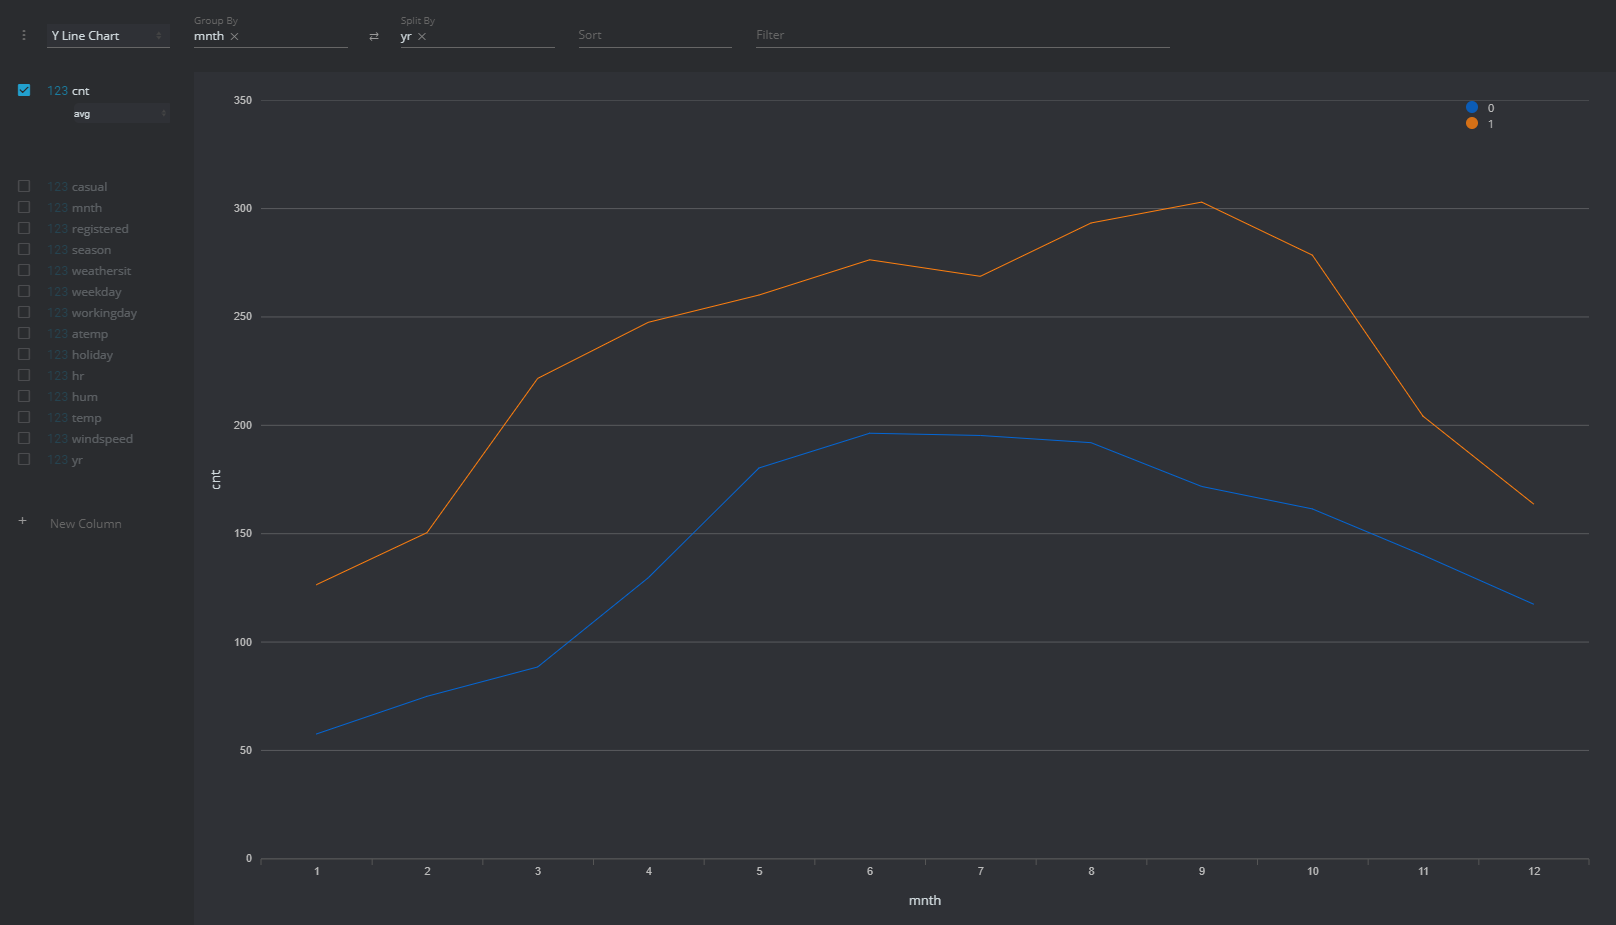

#### Average count group by weekday, split by year
* __Cnt_byYear_byWeekDay__ &#8594; Represents the average number of users each year by Weekday.
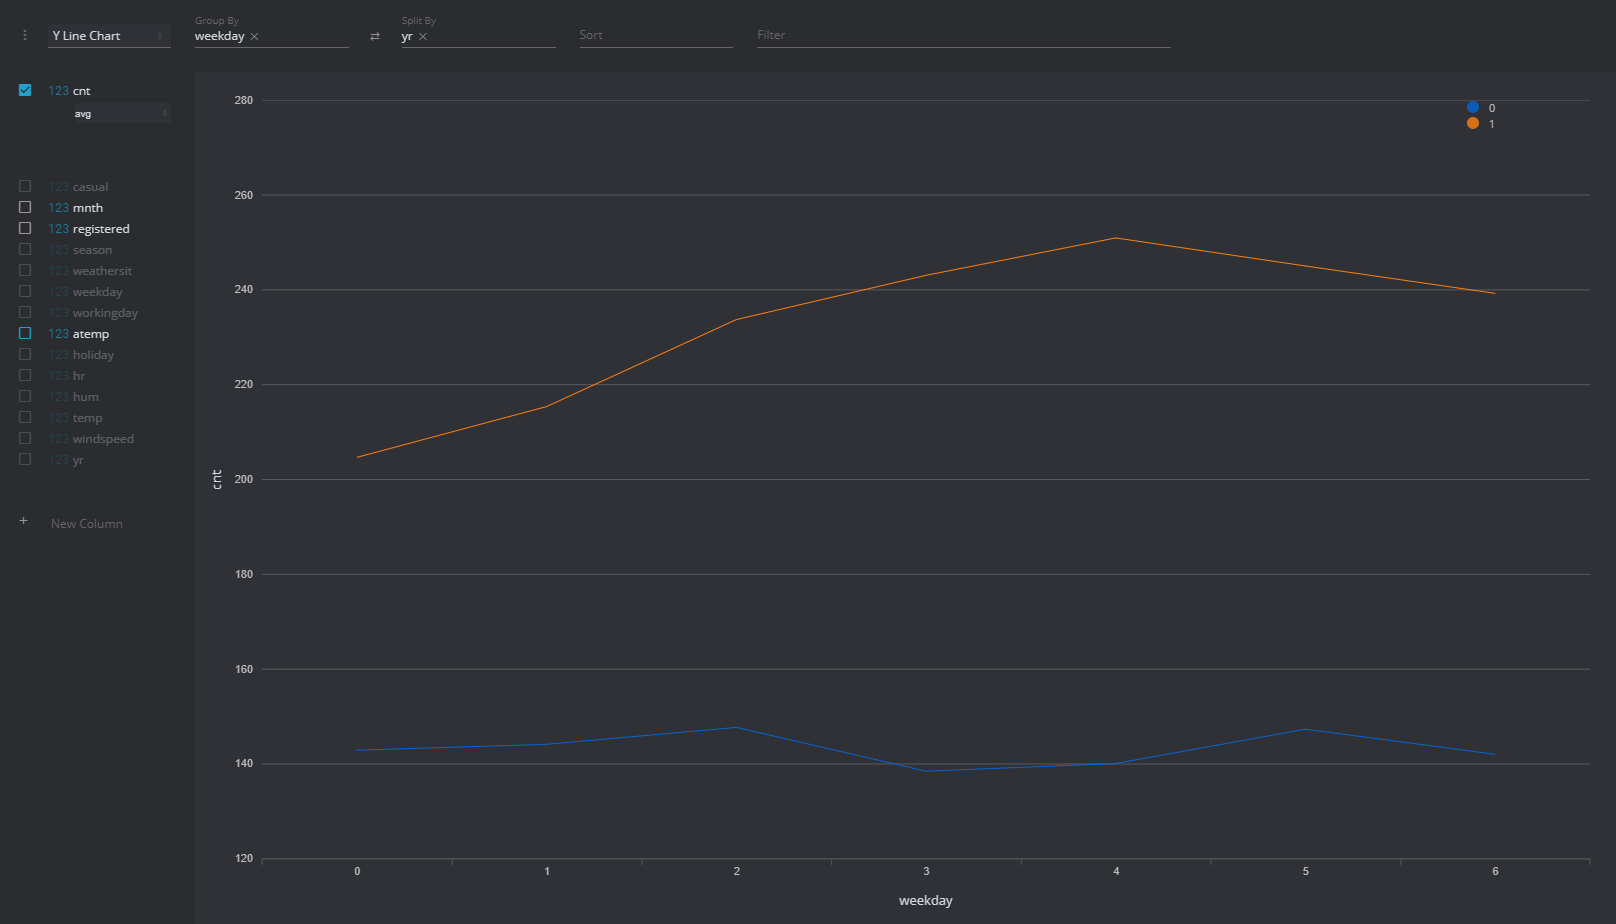

#### Average count by holiday, split by month
* __Cnt_perHoliday_byMonth__ &#8594; Represents the average number of users(casual & registered) per holiday of every month
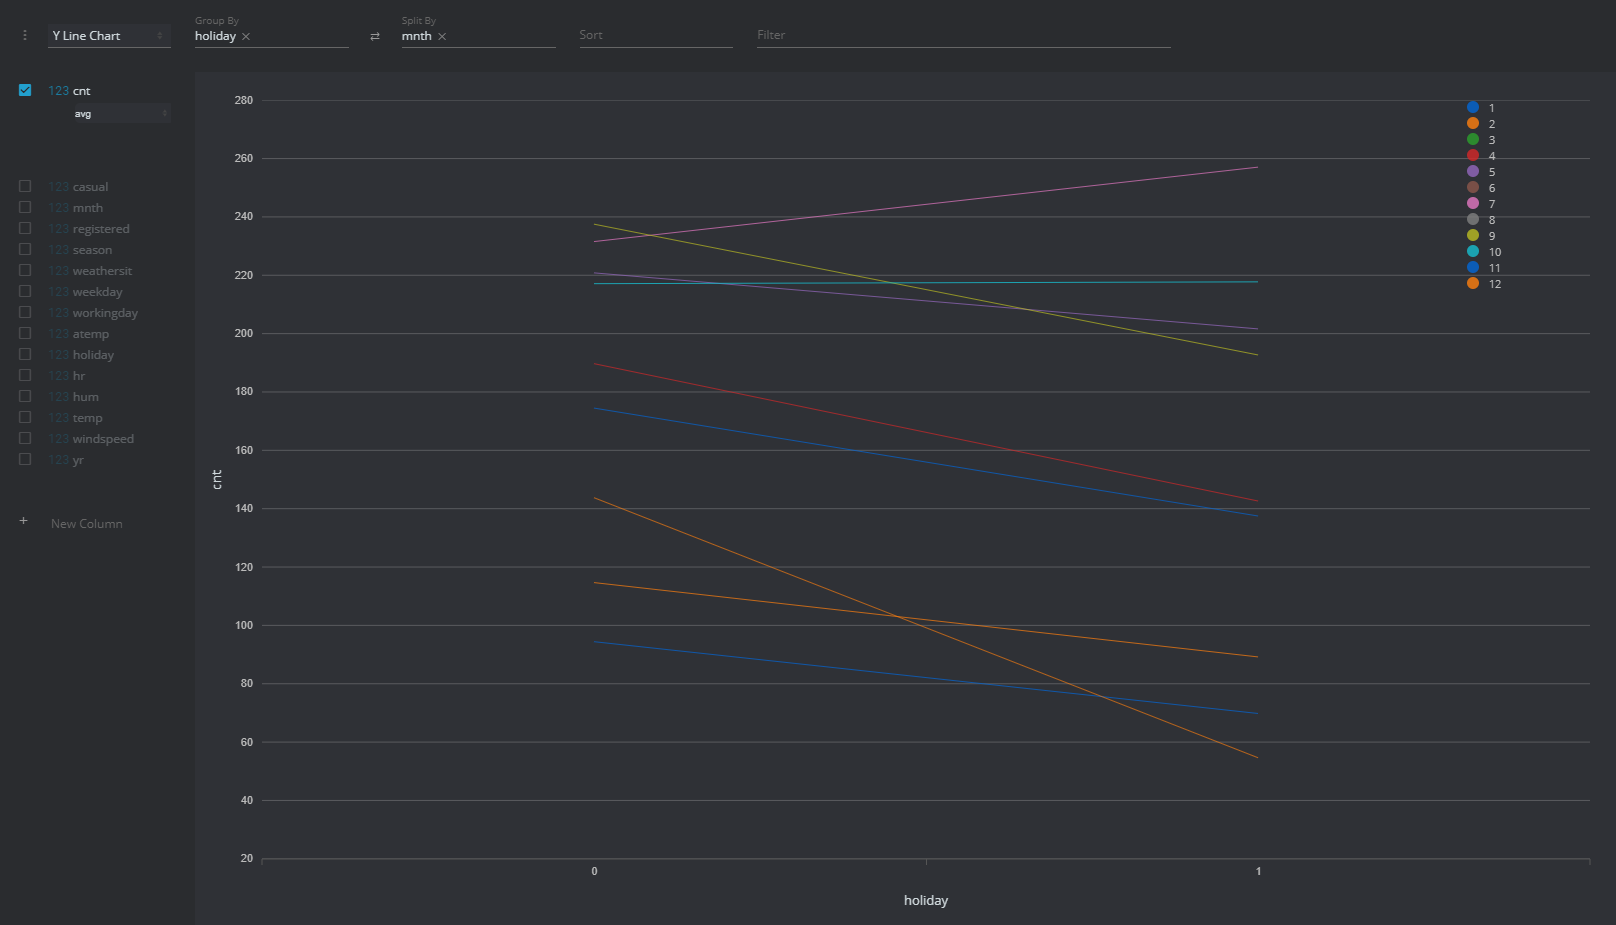

#### Average casual group by weekday, split by weathersit
* __Avg_Casual_per_Weekday_basedOnWeather__ &#8594; Represents the average number of casual users per weekday based on the weather conditions
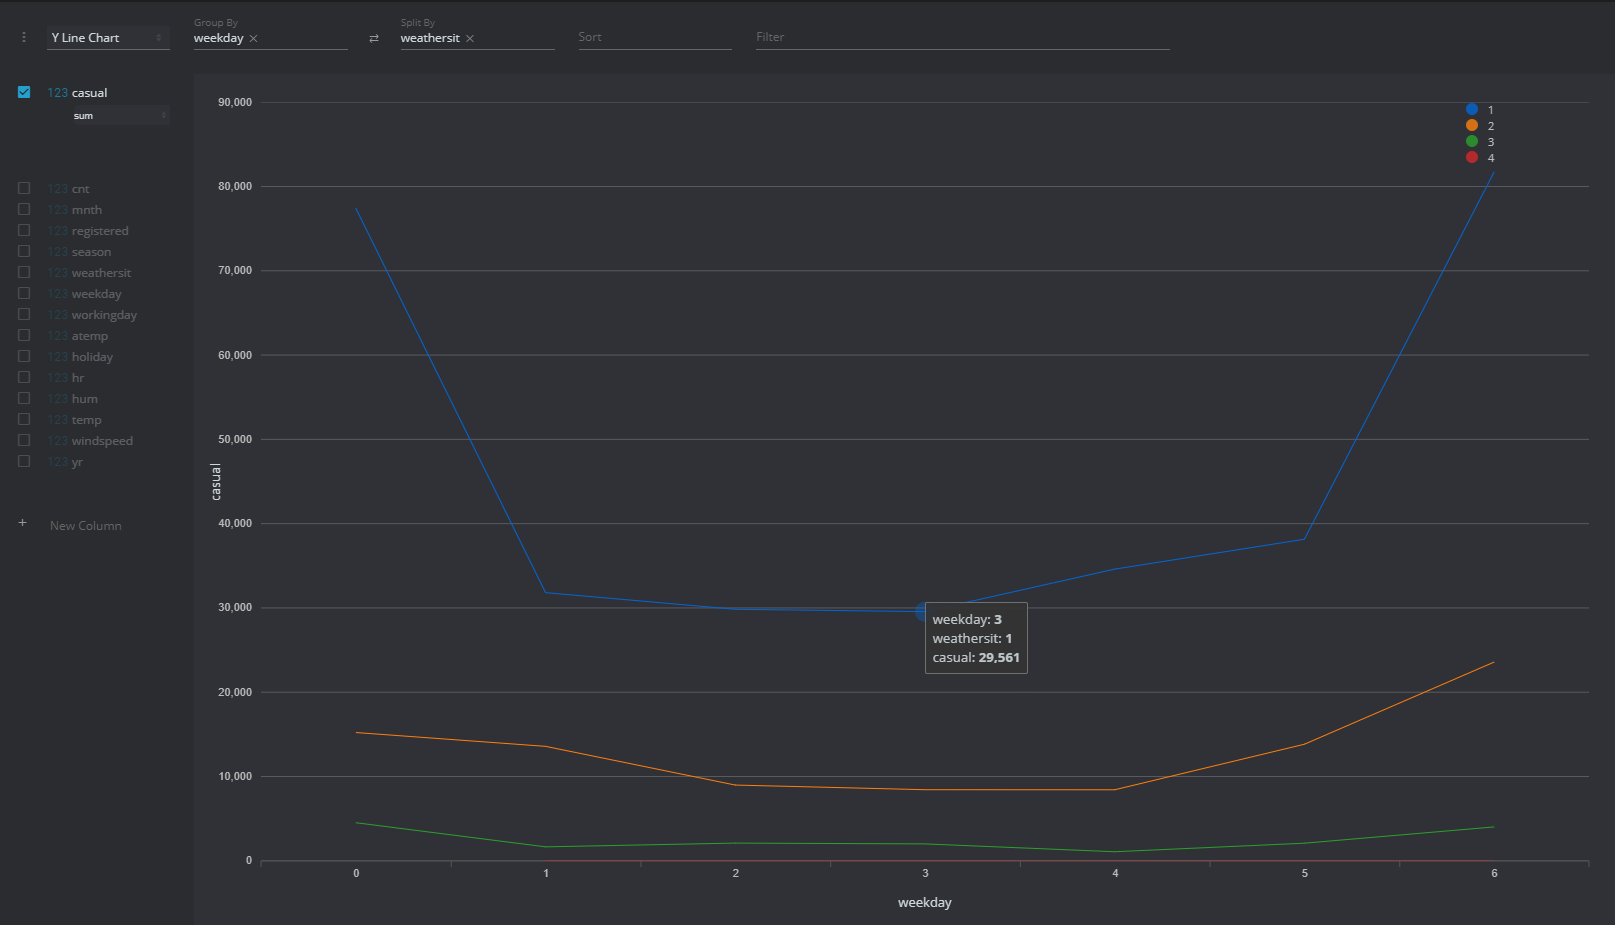

#### Average casual group by workingday
* __Avg_Casual_per_Workingday__ &#8594; Represents the average number of casual users per Business Day
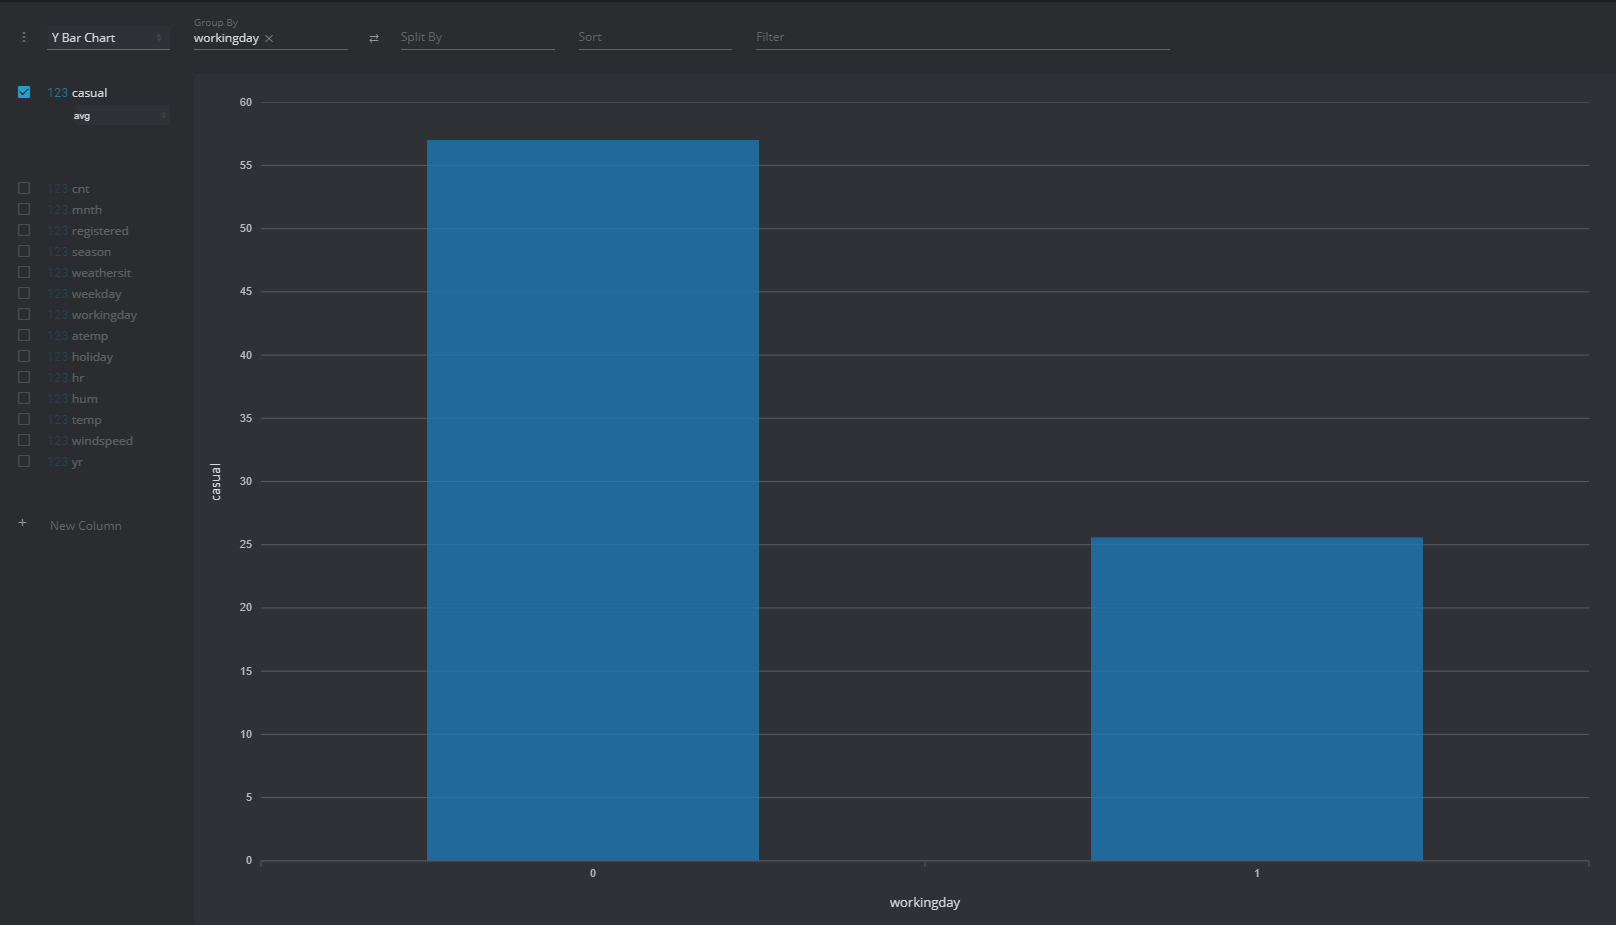

#### Average count group by weekday, split by month
* __avg_cnt_per_day_of_month__ &#8594; Represents the average number of users per weekday, by month
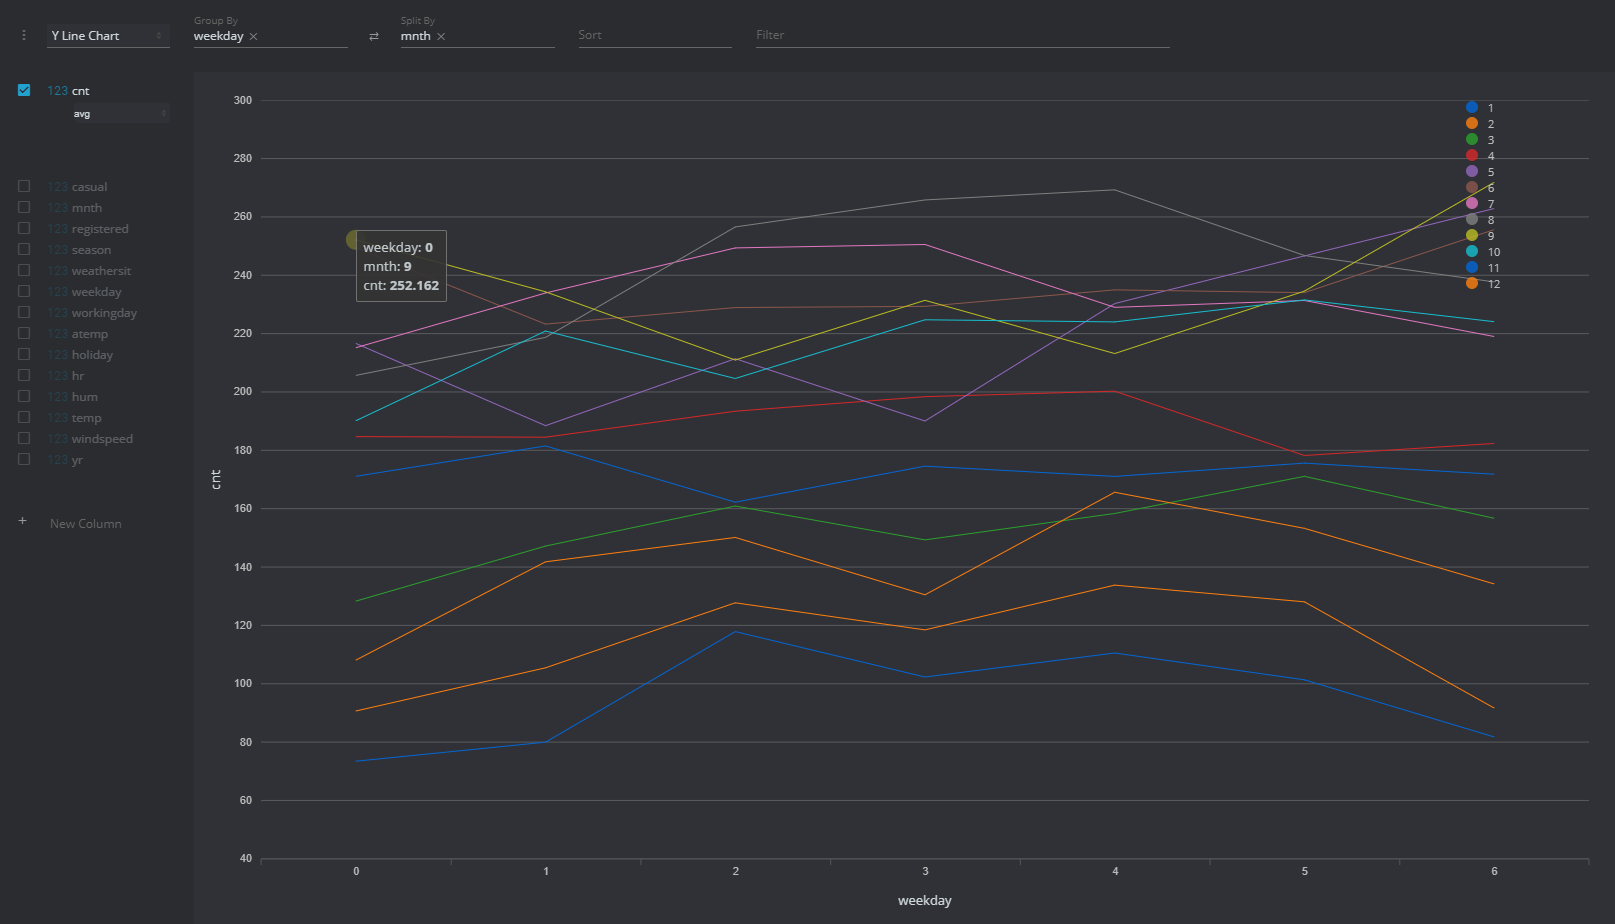

### Libraries
In order to create a balanced model, we decided to try a wide range of Python libraries, and use their modules both individually as well as in conjuction with other modules of the same package, when available (for example in an Ensemble method), or use the results of different methods from different libraries and packages to draw conclusions as to which combination of said results constructs the optimal output. It's important to note that the final submission was the result of multiple predictions, by a wide range of Regressors and NNs, all combined into a single master prediction.

***

#### Scikit-learn 

* *Regression*

Scikit-learn was a focal point in our attempts, particularly in the early stages, due to the ease of use and abundance of choices. Since the base estimation provided to us was predicted using a [Linear Model](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model), we began experimenting with Logistic Regressors, their optimal values, while exploring different options. Lasso and ElasticNet Regressors failed to make much of a difference, if any, and we moved on to use [SVMs](https://scikit-learn.org/stable/modules/svm.html#), which actually made an obvious difference. Insisting on the use of Regressors, we achieved our best score yet with an MLP Regressor. It goes without saying that for each and every one of these methods, multiple tests using GridSearchCV took place, in order to tune the parameters of each Regressor appropriately. 

* *Decision trees*

As we mentioned, Scikit provides a huge range of methods. We decided to use [ensemble models](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), and Decision Trees in particular. Using Random Forest Regressor we saw another big leap in terms of score, and the Extra Trees Regressor improved that score ever so slightly. In fact, Extra Trees Regressor was actually used in the final prediction (along with a few other methods we have not mentioned yet).

* *Ensembles*

We went through a number of Stacking Regressors, finally settling on a Voting Regressor. We favored those which allowed us to provide multiple estimators, as those seemed to predict more accurately. 

* *Gradient Descent*

Last but not least, we used Scikit's Gradient Boosting Regressor in a subset of our prediction, finally settling for the much faster, when dealing with large datasets, Histogram based Gradient Boosting Regressor. It's important to note that the HistGradientBoostingRegressor implementation is still in the experimental stages by Scikit, and it is not enabled by default.

***

#### TensorFlow

Semper ad meliora, we decided to use Neural Networks. We used the groundwork laid by [Keras](Keras.io), a high level TensorFlow API. Our final Neural Network was a 4 layer Sequential Model. Due to stability issues and high variance between each training session, we calculated the mean average of the predictions by multiple instances of said model.

***
 
####  Honorable mentions

* *Pandas*

Storing predictions, merging them, weighing them appropriately and finally extracting the final version would not have been possible without Pandas, which allowed us to interact with CSV data through mostly native Python operators. 

* *Numpy*

Expanding on the above statement, Numpy is not only used in almost every other library mentioned so far, it was also used by us in order to obtain floored values of the final predictions, as those seemed to score higher on a consistent basis.

* *Data Preview*

Although not a Python library per se, mentioning [Data Preview](https://marketplace.visualstudio.com/items?itemName=RandomFractalsInc.vscode-data-preview) is a necessity. It was our go-to visualization tool , and what ultimately led us to create and add additional features in our dataset. It streamlined and automated the process of creating new CSV files from graphs.

### Seperately prediction
Early on in testing it became clear that it wouldn't be efficient to predict the number of users as a whole, as our two user groups(casual and registered) use bikes for different reasons. Through trying out different models, predicting casual and registered users separately produced better results than predicting both of them together as a single unit.

Throughout testing, either with the scikit library, or the tensorflow neural network, it became apparent that the models were struggling to predict the number of casual users(underpredicting or even random predictions)
To summarize the reasons we decided to split predictions were:

1. Different users have different needs and requirements to rent a bike
2. The neural network seemed to predict different results every time we ran it (inconcistensy)
3. The given dataset focuses on the registered users.(Not enough information covering the casual user)

To improve on the casual user prediction we added an extra step to the model(Method: gradient_boost_with_extra_trees), which is activated only for casual user predictions.
This method contains an Ensemble that consists of :
* HistGradientBoostingRegressor
* ExtraTreesRegressor
* RandomForestRegressor

These models are combined using a Voting Regressor.

In [2]:
import os
from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor

import numpy as np
import pandas as pd
from keras import backend as K
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, IsolationForest, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error
from tensorflow_core.python.keras.layers.core import Dense
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.ops.gen_math_ops import log1p
from sklearn.experimental import enable_hist_gradient_boosting
import sklearn
from sklearn.ensemble._hist_gradient_boosting.gradient_boosting import HistGradientBoostingRegressor

# Reads the data input and returns a dataframe with or without one-hot encoding
def read_data(input, is_dataframe=False, one_hot=True, extra_csv=None):
    if not is_dataframe:
        df = pd.read_csv(input)
    else:
        df = input

    df['windspeed'] = normalizer('windspeed', df, for_one_hot=False)

    if extra_csv is None:
        extra_csv = 'count.csv'
    df.rename(columns={'weathersit': 'weather',
                       'mnth': 'month',
                       'hr': 'hour',
                       'yr': 'year',
                       'hum': 'humidity',
                       'cnt': 'count'}, inplace=True)
    df['season'] = df.season.astype('category')
    df['year'] = df.year.astype('category')
    df['month'] = df.month.astype('category')
    df['hour'] = df.hour.astype('category')
    df['holiday'] = df.holiday.astype('category')
    df['weekday'] = df.weekday.astype('category')
    df['workingday'] = df.workingday.astype('category')
    df['weather'] = df.weather.astype('category')

    df = avg_cnt_per_holiday_by_mnth(df)
    df = avg_cnt_per_day_of_month(df, extra_csv)
    df = avg_cnt_By_Year_by_mnth(df)
    df = avg_cnt_per_weekday_of_year(df)
    df = avg_casual_by_weekDay_by_Weather(df)
    df = avg_casual_perWorkingDay(df)

    columns_to_remove = ['atemp']

    df = df.drop(columns_to_remove, axis=1)

    if one_hot:
        one_hot_columns = list(df.columns)  # getting all columns
        non_categorical_columns = ['temp', 'count', 'windspeed', 'humidity', 'casual',
                                   'registered', 'Count_By_Month_of_Year_avg', 'year_day_cnt_avg',
                                   'Month_day_cnt_avg', 'Avg_casual_on_Workday', 'cnt_per_holiday_by_mnth',
                                   'Avg_casual_by_Weekday_by_Weather']  # these are not categorical columns
        one_hot_columns = [x for x in one_hot_columns if x not in non_categorical_columns]  # excluding non-cat columns
        for column in one_hot_columns:
            df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], prefix=column)],
                           axis=1)  # creating one hot encoded columns, adding them to dataset, removing original column

    return df

# Returns X(a dataframe with the selected training columns) and y(a dataframe with the selected prediction columns)
# If nothing is given other than the dataframe, then it separates X,y based on a default
def select_train_columns(df, train_columns=None, pred_column=None):
    if pred_column is None:
        pred_column = 'count'
    all_columns = list(df.columns)
    if train_columns is None:  # if we want, we can specify which columns we want
        train_columns = ['season', 'month', 'hour', 'holiday', 'weekday', 'workingday', 'weather',
                         'temp', 'humidity',
                         'Count_By_Month_of_Year_avg', 'year_day_cnt_avg',
                         'Month_day_cnt_avg', 'cnt_per_holiday_by_mnth',
                         'Avg_casual_by_Weekday_by_Weather', 'windspeed', 'Avg_casual_on_Workday']
    X = df[[x for x in all_columns if x.startswith(tuple(train_columns))]]  # getting all desired
    if pred_column in all_columns:  # if used for train set, we need to return the results too
        y = df[pred_column]
    else:
        y = None
    return X, y


# The Ensemble model for the casual user prediction
def gradient_boost_with_extra_trees(X, y):
    gb = HistGradientBoostingRegressor(loss='least_absolute_deviation', learning_rate=0.12, max_depth=150)

    ex = ExtraTreesRegressor(n_jobs=-1, max_depth=100, n_estimators=100, random_state=0)

    rf = RandomForestRegressor(random_state=0, max_depth=25, n_estimators=900)
    done = False
    while not done:
        # try:
        stacking = sklearn.ensemble.VotingRegressor(
            estimators=[('gradientBoost', gb), ('randomForest', rf), ("extraTrees", ex)],
            n_jobs=-1)
        stacking.fit(X, y)
        done = True
    # except ValueError:
    # print("Caught ValueError")
    return stacking

#Creates a submission csv for kaggle
def create_submission(predictions, filename=None):
    if filename is None:
        filename = 'submission.csv'
    submission = pd.DataFrame()
    submission['Id'] = range(len(predictions))
    submission['Predicted'] = predictions
    submission.to_csv(filename, index=False)
    
# Appends the average count per holiday by month as a column to the given dataframe
def avg_cnt_per_holiday_by_mnth(df):
    extra = pd.read_csv('cnt_per_holiday_by_mnth.csv')
    cnt_per_holiday_by_mnth = []
    for i in range(df.shape[0]):
        holiday = df.holiday[i]
        mnth = df.month[i]
        cnt_per_holiday_by_mnth.append(extra.iloc[holiday][mnth - 1])
    df['cnt_per_holiday_by_mnth'] = cnt_per_holiday_by_mnth
    return df

# Appends the average count per weekday based on the year as a column to the given dataframe
def avg_cnt_per_weekday_of_year(df):
    extra = pd.read_csv('cntByYrByWd.csv')
    cnt_avg_peryr_per_weekday = []
    for i in range(df.shape[0]):
        weekday = df.weekday[i]
        year = df.year[i]
        cnt_avg_peryr_per_weekday.append(extra.iloc[weekday][year])
    df['year_day_cnt_avg'] = cnt_avg_peryr_per_weekday
    return df

# Appends the average count per day of the month as a column to the given dataframe
def avg_cnt_per_day_of_month(df, extra_csv=None):
    if extra_csv is None:
        extra_csv = 'count.csv'
    extra = pd.read_csv(extra_csv)
    cnt_avg_perMnth_perDay = []
    for i in range(df.shape[0]):
        month = df.month[i]
        day = df.weekday[i]
        cnt_avg_perMnth_perDay.append(extra.iloc[month - 1][day])
    df['Month_day_cnt_avg'] = cnt_avg_perMnth_perDay
    return df

# Appends the count by year by month as a column to the given dataframe
def avg_cnt_By_Year_by_mnth(df, extra_csv=None):
    if extra_csv is None:
        extra_csv = 'cntByYrByMnth.csv'
    extra = pd.read_csv(extra_csv)
    avg_cnt_By_Year_by_Month = []
    for i in range(df.shape[0]):
        year = df.year[i]
        month = df.month[i]
        if year == 0:
            avg_cnt_By_Year_by_Month.append(extra.iloc[month - 1][2])
        else:
            avg_cnt_By_Year_by_Month.append(extra.iloc[month + 10][2])
    df['Count_By_Month_of_Year_avg'] = avg_cnt_By_Year_by_Month
    return df

# Appends the average number of casual users by weekday based on weather as a column to the given dataframe
def avg_casual_by_weekDay_by_Weather(df, extra_csv=None):
    if extra_csv is None:
        extra_csv = 'Avg_casual_perWeekday_basedOnWeather.csv'
    extra = pd.read_csv(extra_csv)
    avg_casual_by_weekday_by_weather = []
    for i in range(df.shape[0]):
        weekday = df.weekday[i]
        weather = df.weather[i]
        avg_casual_by_weekday_by_weather.append(extra.iloc[weekday][weather - 1])
    df['Avg_casual_by_Weekday_by_Weather'] = avg_casual_by_weekday_by_weather
    return df

# Appends the average number of casual users per business day as a column to the given dataframe
def avg_casual_perWorkingDay(df, extra_csv=None):
    if extra_csv is None:
        extra_csv = 'Avg_casual_perWorkingDay.csv'
    extra = pd.read_csv(extra_csv)
    avg_casual_perWorkDay = []
    for i in range(df.shape[0]):
        workingDay = df.workingday[i]
        avg_casual_perWorkDay.append(extra.iloc[workingDay][1])
    df['Avg_casual_on_Workday'] = avg_casual_perWorkDay
    return df

# Normalizes the given column of the df and prepares it for one-hot if required
def normalizer(column, df, for_one_hot=False):
    x = df[[column]].values.astype(float)
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)

    if for_one_hot:
        for i in range(len(x_scaled)):
            if x_scaled[i] <= 0.25:
                x_scaled[i] = int(0)
            elif x_scaled[i] <= 0.5:
                x_scaled[i] = int(1)
            elif x_scaled[i] <= 0.75:
                x_scaled[i] = int(2)
            else:
                x_scaled[i] = int(3)

    return x_scaled

# returns the absolute value of the first item of the list
def transform_list_item(list):
    return abs(list[0])

# Brings given list items that are negative to zero
def bring_to_zero(list):  # negative rental numbers don't exist, so we set them to 0
    for i, y in enumerate(list):
        if list[i] < 0:
            list[i] = 0
    return list

# The neural network model used 
def sequential_nn_model(X_train, y_train):
    model = Sequential([
        Dense(100, activation='relu', input_shape=(X_train.shape[1],)),

        Dense(40, activation='relu'),

        Dense(20, activation='relu'),

        Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam',
                  loss=rmsle,
                  metrics=['mean_squared_logarithmic_error'])

    hist = model.fit(X_train, y_train, epochs=50, verbose=0)
    return model

# Returns the scores of the tested model(Used for training and testing locally)
def get_scores(name, test_set, predictions):
    string = '\n'
    string += 'RMSLE for ' + name + ': ' + str(np.sqrt(mean_squared_log_error(test_set, predictions)))
    string += '\n' + 'R2 for ' + name + ': ' + str(r2_score(test_set, predictions)) + '\n'
    return string

# Custom loss function used in the neural network
def rmsle(y, y0):
    return K.sqrt(K.mean(K.square(log1p(y) - log1p(y0))))

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 13000)

predict_columns = ['casual', 'registered', 'count']

merged_pred = {}  # dictionary with predictions for each column
merged_pred_df = {}  # dictionary with dataframes
mean_pred = {}  # dictionary with mean results
y_tests = {}
for column in predict_columns:
    print("Training for " + column + '\n')
    df = read_data('train.csv', one_hot=False, extra_csv=column + '.csv')
    df_test = read_data('test.csv', one_hot=False,
                        extra_csv=column + '.csv')  # random forest is used without one-hot encoding

    X, y = select_train_columns(df, pred_column=column)
    # Training and test data is created by splitting the main data. 30% of test data is considered
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    y_tests[column] = deepcopy(y_test)
    df_test = select_train_columns(df_test, pred_column=column)[0]  # getting the correctly encoded parameters
    merged_pred[column] = []

    if column == 'casual':
#         print('gbrf')
        done = False
        while not done:
            try:
                casual_model = gradient_boost_with_extra_trees(X_train, y_train)
                done = True
            except ValueError:
                li=0
#                 print("Caught ValueError")

        casual_y_pred = casual_model.predict(X_test)
        for i in range(6):
            merged_pred[column].append(pd.Series(casual_y_pred, name='pred_gbrf' + str(i)))

    # ----- using Random Forest -----
    if column =='casual':
        REPETITIONS = 15
    else:
        REPETITIONS = 10
    rf = ExtraTreesRegressor(n_jobs=-1, max_depth=75, n_estimators=900, random_state=0)
    rf.fit(X_train, y_train)
    rf_pred = rf.predict(X_test)
    rf_pred = bring_to_zero(rf_pred)
    for i in range(REPETITIONS):
        merged_pred[column].append(pd.Series(rf_pred, name='pred_rf' + str(i)))
#     print(merged_pred[column])
    df = read_data('train.csv', extra_csv=column + '.csv')
    df_test = read_data('test.csv', extra_csv=column + '.csv')

    X, y = select_train_columns(df, pred_column=column)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  # splitting

    df_test['weather_4'] = 0
    df_test = select_train_columns(df_test, pred_column=column)[0]

    # ------- using neural network -----
    i = 0
    if column == 'casual':
        reps = 13
    elif column == 'registered':
        reps = 20
    else:
        reps = 13
    while i < reps:
        nn = sequential_nn_model(X_train, y_train)  # fitting neural network model on X and y
        nn_pred = nn.predict(X_test)  # making prediction
        nn_pred = [transform_list_item(x) for x in nn_pred]
#         print(nn_pred[0:5])
        if all(pred == 0.0 for pred in nn_pred):
#             print("fixing nn")
            continue
        merged_pred[column].append(pd.Series(nn_pred, name='pred_nn' + str(i)))
        i += 1
        
    # ------- using mlp -------
    # for i in range(0):
    #     mlp = MLPRegressor(hidden_layer_sizes=(100, 60, 40, 20), activation='relu', solver='lbfgs', alpha=0.0001,
    #                        verbose=False,
    #                        max_iter=400)
    #     mlp.fit(X_train, y_train)
    #     mlp_pred = mlp.predict(X_test)
    #     mlp_pred = bring_to_zero(mlp_pred)
    #     merged_pred[column].append(pd.Series(mlp_pred, name='pred_mlp' + str(i)))

    merged_pred_df[column] = pd.concat(merged_pred[column], axis=1)
#     print(merged_pred_df[column].head())
    # getting the mean
    mean_pred[column] = pd.DataFrame()
    mean_pred[column]['avg'] = merged_pred_df[column].mean(axis=1)  # getting the mean average of the columns


summed_pred = mean_pred['casual'] + mean_pred['registered']
summed_pred_array = summed_pred.to_numpy()
floor_array = deepcopy(summed_pred_array)
floor_array = np.floor(floor_array)
print(get_scores("Casual + registered AVG prediction", y_test, summed_pred))
print(get_scores("Count AVG prediction", y_test, bring_to_zero(mean_pred['count']['avg'].tolist())))
print(get_scores("Casual + registered AVG floored prediction", y_test, floor_array))

# create_submission(floor_array, filename='LastHope.csv')

Training for casual

gbrf
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[7.6401887, 72.58629, 35.264378, 3.309139, 7.559919]
[5.349546, 82.9221, 33.341297, 2.3734243, 7.3925138]
[1.0270394, 43.09922, 24.065649, 1.4463177, 5.4226136]
[3.6892035, 53.685085, 26.437881, 1.8599888, 7.34756]
[3.8830733, 93.130165, 31.55592, 2.8249187, 8.172174]
[2.7029157, 46.252235, 31.37549, 3.064095, 6.869955]
[0.0, 0.0, 0.0, 0.0, 0.0]
fixing nn
[2.2557235, 44.861515, 25.99533, 1.7192681, 6.2140117]
[0.0, 0.0, 0.0, 0.0, 0.0]
fixing nn
[0.0, 0.0, 0.0, 0.0, 0.0]
fixing nn
[1.0207597, 20.591545, 21.338123, 1.8044258, 4.8070307]
[0.0, 0.0, 0.0, 0.0, 0.0]
fixing nn
[5.351723, 71.453926, 34.60727, 1.3916801, 8.0029955]
[7.8539357, 94.961845, 38.735424, 3.7646608, 11.762603]
[3.5308745, 58.847244, 29.844372, 2.4212728, 7.306849]
[0.0, 0.0, 0.0, 0.0, 0.0]
fixing nn
[0.0, 0.0, 0.0, 0.0, 